*Jeffrey Ching - Application Case Study - Predicting Future Hotel Booking Cancellations*

# **Business Context and Problem Definition**

## Business Context

With the increasing popularity and ease-of-access of online hotel booking platforms, customers tend to make reservations in advance to avoid any last minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations becomes a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group have been contending with the challenge of rising cancellations for nearly a year now. However, the last three months have seen a rise of inventory loss (bookings) due to cancellations rising to an all-time high of 18% and has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted INN Hotels Group's profit margins.
 
The group has been using heuristic mechanisms (rule and domain expert based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far, neither efficient nor scalable, as evident from the magnitude of losses they are incurring.

The group has decided that they need a more data-driven solution to predict the likelihood of a booking being cancelled as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them to significantly minimize revenue loss and improve operational efficiency.

The group is looking for a data science backed solution that will help them predict the likelihood of a booking getting cancelled so that they can take measures to fill in potential vacancies.


# **Data Gathering**


## Importing the necessary libraries

In [1]:
# libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libraries to deploy the ML model
import os
import joblib
import gradio as gr

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# removing the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# setting the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 2 decimal points
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# library to split data
from sklearn.model_selection import train_test_split

# library to build ML model
from sklearn.tree import DecisionTreeClassifier

# library to tune ML model
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# libraries to evaluate the ML model
from sklearn.metrics import f1_score, make_scorer

## Loading the dataset

In [2]:
# load dataset
path = "datasets/"
# The sample data was obtained by taking specific attributes from website data, agencies data, and property data and collating them together
hotel = pd.read_csv(path + "INNHotelsGroup.csv")

In [3]:
hotel.sample(10, random_state=10)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
18212,103,Offline,0,115.00,1,0,2018-04-19,0,2,Canceled
3267,86,Online,2,90.00,2,1,2018-11-04,0,2,Not_Canceled
28472,20,Online,1,92.67,2,1,2018-12-09,0,2,Not_Canceled
34178,22,Online,1,126.04,2,4,2018-12-28,0,10,Not_Canceled
35404,109,Online,4,105.21,2,2,2018-07-06,0,4,Not_Canceled
31551,30,Offline,0,127.15,1,0,2018-10-28,0,1,Not_Canceled
30927,192,Offline,0,100.00,2,0,2018-08-25,0,3,Not_Canceled
30473,278,Online,0,103.95,2,2,2018-07-16,1,1,Canceled
27445,0,Online,0,85.93,1,0,2018-05-12,0,1,Not_Canceled
33154,37,Online,1,92.31,1,4,2018-12-15,0,9,Canceled


In [4]:
print(hotel.dtypes)

lead_time                       int64
market_segment_type            object
no_of_special_requests          int64
avg_price_per_room            float64
no_of_adults                    int64
no_of_weekend_nights            int64
arrival_date                   object
required_car_parking_space      int64
no_of_week_nights               int64
booking_status                 object
dtype: object


In [5]:
print(min(pd.to_datetime(hotel.arrival_date)))
print(max(pd.to_datetime(hotel.arrival_date)))

2017-07-01 00:00:00
2018-12-31 00:00:00


* This dataset consists 1.5 years of booking data for the INN Hotels Group from second half of 2017 to the full 2018 year.

# **Exploratory Data Analysis**


In [6]:
data = hotel.copy()

In [7]:
# checking the statistical summary of the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,36275.00,85.23,85.93,0.00,17.00,57.00,126.00,443.00
no_of_special_requests,36275.00,0.62,0.79,0.00,0.00,0.00,1.00,5.00
avg_price_per_room,36275.00,103.42,35.09,0.00,80.30,99.45,120.00,540.00
no_of_adults,36275.00,1.84,0.52,0.00,2.00,2.00,2.00,4.00
no_of_weekend_nights,36275.00,0.81,0.87,0.00,0.00,1.00,2.00,7.00
required_car_parking_space,36275.00,0.03,0.17,0.00,0.00,0.00,0.00,1.00
no_of_week_nights,36275.00,2.20,1.41,0.00,1.00,2.00,3.00,17.00


* The number of adults (no_of_adults) ranges from 0 to 4, which is usual.
* The range of the number of weeknights and weekend nights for hotel stays seems fine. Though 7 weekends might be a very long stay.
* At least 75% of the customers do not require car parking space.
* On average, customers book 85 days in advance (_lead_time_). There is also a very large difference in the 75th percentile (126) and maximum value (443 days) for the lead time which indicates there might be outliers present.
* The average price per room is 103 euros. There is a very large difference between the 75th percentile (120) and the maximum value (540) which indicates there might be outliers present.

In [8]:
# function to create a barplot with percent
def count_plot(data, column):
    total = data[column].count()
    ax = sns.countplot(data,x=column,hue=column)
    for c in ax.containers:
        ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    plt.show()

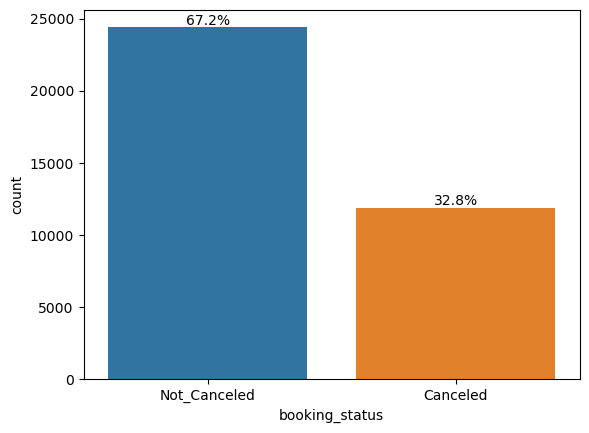

In [9]:
count_plot(data,"booking_status")

- Approximately one-third of bookings were canceled.

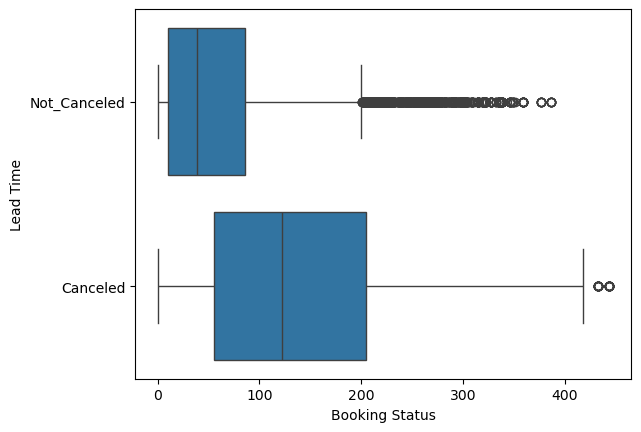

In [10]:
# visualize the relationship between lead time and booking cancellation
sns.boxplot(data=data, x="lead_time", y="booking_status")
plt.xlabel('Booking Status')
plt.ylabel('Lead Time');

* We observe that the higher the lead time, the higher the chances of cancellation.

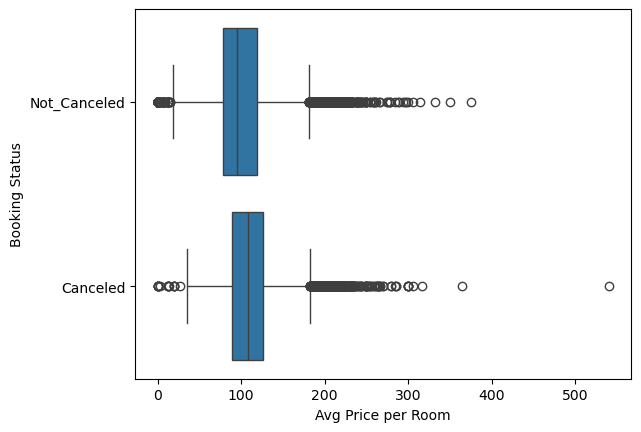

In [11]:
# visualize the relationship between avg room price and booking cancellation
# plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="avg_price_per_room", y="booking_status")
plt.xlabel('Avg Price per Room')
plt.ylabel('Booking Status');

In [12]:
# we can bucket the rooms to see if price differences substantially make a difference in cancellation ratios
avg_price_per_room_bucketed = pd.cut(data["avg_price_per_room"],6)
pd.crosstab(avg_price_per_room_bucketed, data["booking_status"], normalize="index")

booking_status,Canceled,Not_Canceled
avg_price_per_room,,
"(-0.54, 90.0]",0.23,0.77
"(90.0, 180.0]",0.39,0.61
"(180.0, 270.0]",0.38,0.62
"(270.0, 360.0]",0.43,0.57
"(360.0, 450.0]",0.50,0.50
"(450.0, 540.0]",1.00,0.00


- The box plot shows booking status marginally varies with the average price per room at around \\$100 per room with the average price per room of cancelled rooms is just slightly higher than uncancelled rooms.
- We see that rooms are more likely to be cancelled above starting around \\$270 per room.

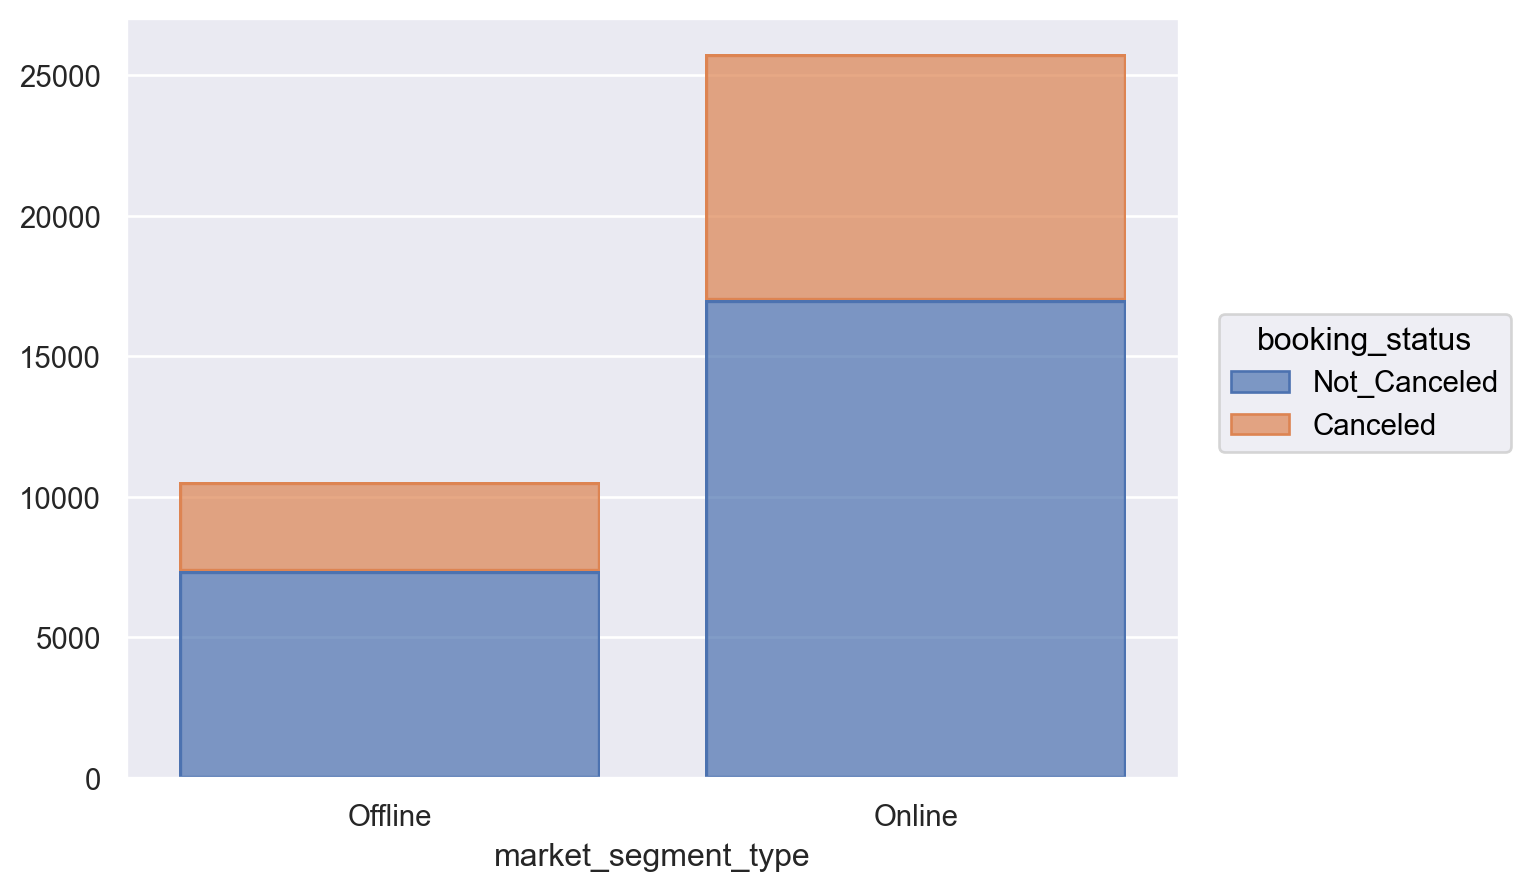

In [13]:
# Visualize the percent volume of bookings cancelled vs not cancelled based on online or offline segments
so.Plot(data, x="market_segment_type", color="booking_status").add(so.Bar(), so.Count(), so.Stack())

In [14]:
pd.crosstab(data["market_segment_type"], data["booking_status"], normalize="index")

booking_status,Canceled,Not_Canceled
market_segment_type,,
Offline,0.30,0.70
Online,0.34,0.66


* Offline bookings have witnessed a slightly lower rate of cancellation compared to online bookings (4%)
* However we see a much greater number of bookings are made online than offline which indicates an opportunity to improve the volume of direct bookings offline.

In [15]:
# Analyze trend of number of bookings per month

# convert the 'arrival_date' column to datetime type
data['arrival_date'] = pd.to_datetime(data['arrival_date'])

# extract month and yerar from 'arrival_date' column
data['arrival_month'] = data['arrival_date'].dt.month
data['arrival_year'] = data['arrival_date'].dt.year

# group the data by arrival month and year and extract the count of bookings
monthly_data = data.groupby(["arrival_year","arrival_month"])["booking_status"].count().to_frame().reset_index()
monthly_data.columns = ['Year','Month','Bookings']
monthly_data

,Year,Month,Bookings
0,2017,7,363
1,2017,8,1014
2,2017,9,1649
3,2017,10,1913
4,2017,11,647
5,2017,12,928
6,2018,1,1014
7,2018,2,1704
8,2018,3,2358
9,2018,4,2736


In [16]:
data.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status', 'arrival_month', 'arrival_year'],
      dtype='object')

In [17]:
# We can filter on just the latest year of data as it seems we were not capturing data in full prior to 2018
data = data[data['arrival_year'] == data['arrival_year'].max()]
del data['arrival_year']

<Axes: xlabel='Month', ylabel='Bookings'>

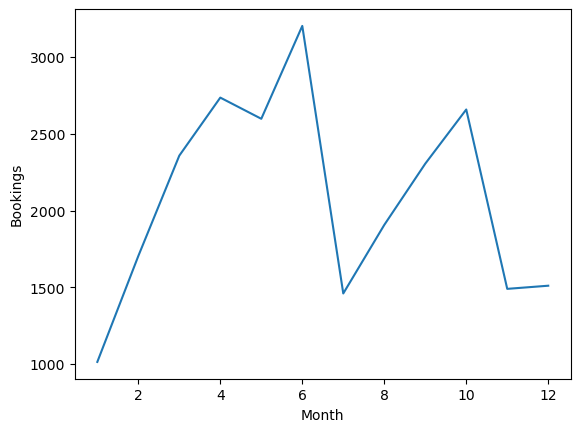

In [18]:
# Visualize the number of bookings across months
sns.lineplot(data=monthly_data, x="Month", y="Bookings",errorbar=None)

* The month-over-month trend shows that the number of bookings rise from January to June, peaking at June and dropping, then rising further from June through October where it reaches a peak.
* From October through December we see a steep drop (~35%) in bookings.

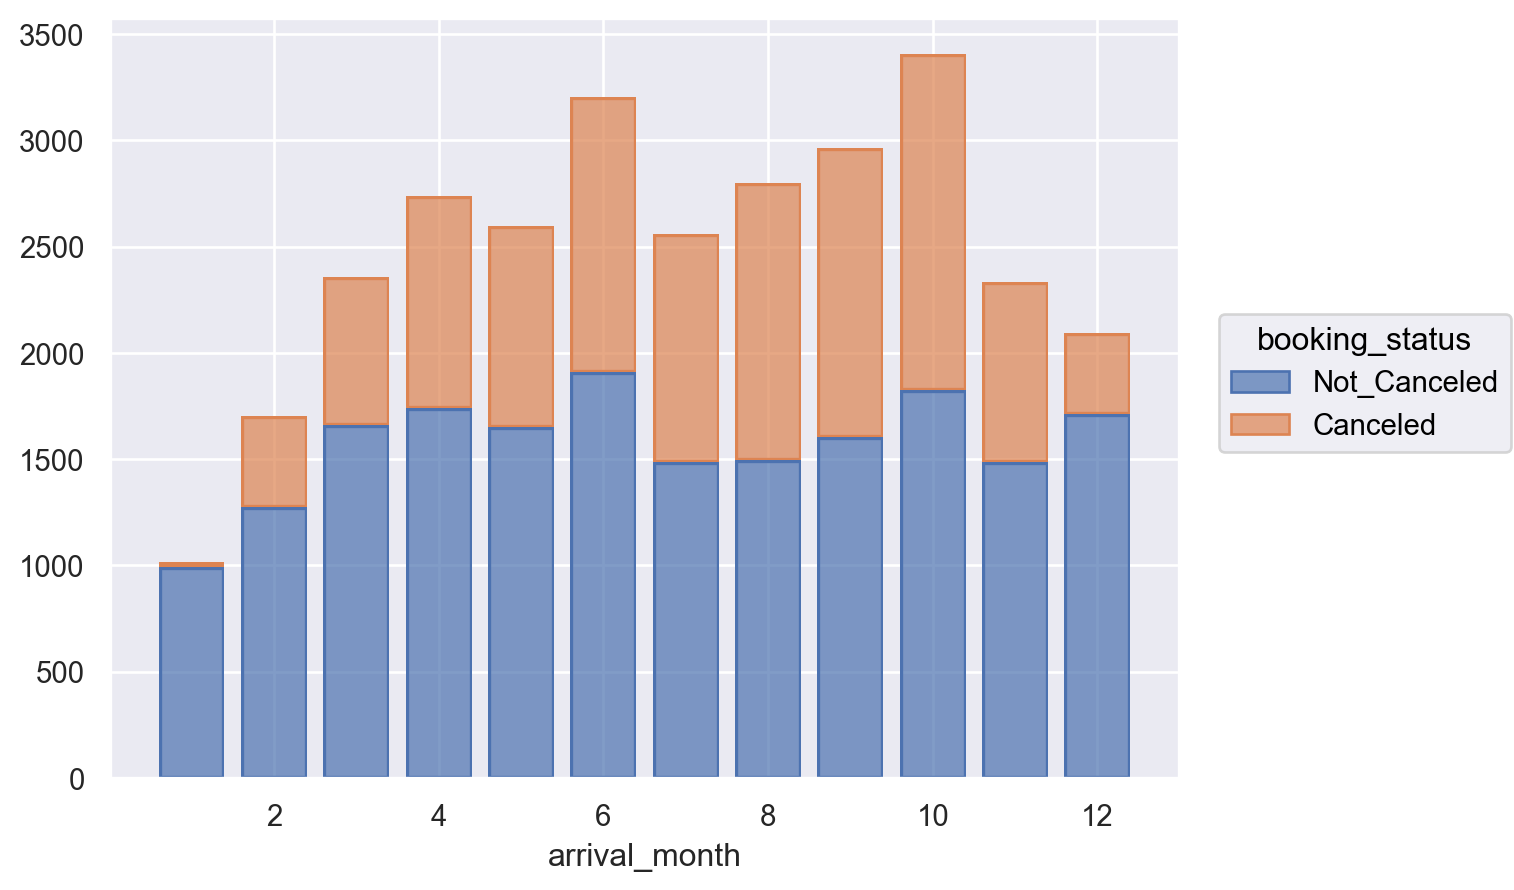

In [19]:
# We can visualize trend of number of bookings per month
so.Plot(data, x="arrival_month", color="booking_status").add(so.Bar(), so.Count(), so.Stack())

In [20]:
pd.crosstab(data["arrival_month"], data["booking_status"], normalize="index")

booking_status,Canceled,Not_Canceled
arrival_month,,
1,0.02,0.98
2,0.25,0.75
3,0.30,0.70
4,0.36,0.64
5,0.36,0.64
6,0.40,0.60
7,0.42,0.58
8,0.47,0.53
9,0.46,0.54


* January and December saw a significantly lower rate of cancellation compared to the other months, and July witnesses the highest rate of cancellation.
* Cancellations appear higher during the summer months (June through August).

### EDA Summary

* **Booking Status:** Approximately one third of bookings had been cancelled from second half of 2017 through 2018 year.
* **Lead Time vs Booking Status:** The higher the lead time of advanced bookings correlates to a higher the chance of cancellation.
* **Market Segment Type Vs Booking Status:** The cancellation of bookings is independent of the booking segment (online or offline). Customer cancellations behavior appear similarly for both segments, suggesting a flexible cancellation policy for both hotels and third-party vendors.
* **Arrival Month Vs Booking Status:** January (\~2.5%) and December (\~10%) witnessed a significantly lower rate of cancellation compared to the other months (average \~30%), while July (\~40%) witnessed the highest rate of cancellation.
* **Average price per room vs Booking status** The booking status does not apper to vary significantly with the average price per room.
* **Booking Trend:** Monthly booking trends show that the number of bookings rise from January to April, remain consistent from April to July, then rise again till October where it reaches a peak, and then drops down again in October through December.
* **Cancellations Trend:** Cancellations appear to be more prevalant and peak during the summer months. We cannot infer a specific cause but this can be possibly related to customer booking behavior (i.e. booking multiple hotels, change of summer plans, etc.)


# **Model Building**


## Data Preprocessing

In [21]:
# We can encode our target attribute (booking status) from categorical to numerical value (1 if cancelled, 0 if not) 
# as the first data pre-processing step to build our prediction model to detect future cancellations.
data_processed = data.copy()
data_processed["booking_status"] = np.where(data["booking_status"].str.lower() == "canceled", 1, 0)

In [22]:
data_processed["booking_status"] = data_processed["booking_status"].astype(int)

In [23]:
data_processed.head()

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,arrival_month
1,5,Online,1,106.68,2,2,2018-11-06,0,3,0,11
2,1,Online,0,60.00,1,2,2018-02-28,0,1,1,2
3,211,Online,0,100.00,2,0,2018-05-20,0,2,1,5
4,48,Online,0,94.50,2,1,2018-04-11,0,1,1,4
5,346,Online,1,115.00,2,0,2018-09-13,0,2,1,9


In [24]:
# Create the train and test train split
X = data_processed.drop(["booking_status","arrival_date"], axis=1)
y = data_processed["booking_status"]

# encode the categorical variables
X = pd.get_dummies(X, drop_first=True)

# apply a 70:30 split of the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [25]:
X.head()

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,arrival_month,market_segment_type_Online
1,5,1,106.68,2,2,0,3,11,True
2,1,0,60.00,1,2,0,1,2,True
3,211,0,100.00,2,0,0,2,5,True
4,48,0,94.50,2,1,0,1,4,True
5,346,1,115.00,2,0,0,2,9,True


## **Model Training and Evalution**

In [26]:
# Define a ML model to build -- we'll apply a default decision tree classifier first
model = DecisionTreeClassifier(random_state=1)

# Train the model on the training dataset
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [27]:
y_pred = model.predict(X_train)

In [28]:
y_train.value_counts()

booking_status
0    13168
1     7664
Name: count, dtype: int64

In [29]:
# function to visualize confusion matrix with percentage correlations
def confusion_matrix_model(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray( #creates the percentages
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

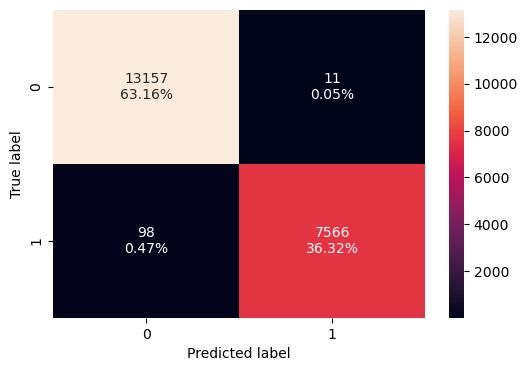

In [30]:
# confusion matrix for train data
confusion_matrix_model(model, X_train, y_train)

In [31]:
# evaluate the model performance on the train data -- we'll use F1 score to balance precision and recall
model_train_predictions = model.predict(X_train)
model_train_score = f1_score(y_train, model_train_predictions)

print("Model Score on Train Data:", np.round(100*model_train_score, 2))

Model Score on Train Data: 99.28


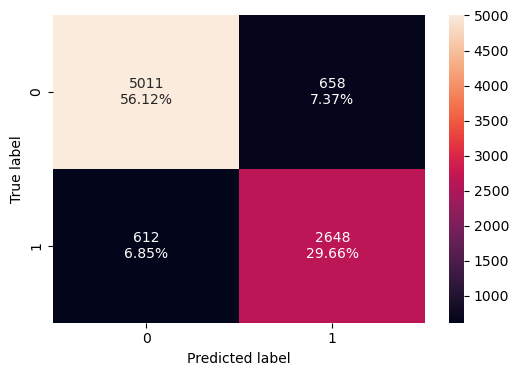

In [32]:
# confusion matrix for test data
confusion_matrix_model(model, X_test, y_test)

In [33]:
# evaluating the model performance on the test data
model_test_predictions = model.predict(X_test)
model_test_score = f1_score(y_test, model_test_predictions)

print("Model Score on Test Data:", np.round(100*model_test_score, 2))

Model Score on Test Data: 80.66


###### Observations:

* The model was able to correctly predict 56.12% of bookings as not being cancelled on the test data
  * Business consequence for errors: Inaccurate predictions for a cancelled booking when it isn't can lead to overbooking, which is amplified during peak seasons or high-demand periods.
* The model was able to correctly predict 29.66% a booking as being cancelled
  * Business consequence for errors: Inaccurate predictions can lead to unsold rooms, resulting in potential loss of revenue.

## Observations from Model Evaluation

Our ML model has a score of 98.97% on the train data and 80.8% on the test data respectively.

- This shows that while the model work really well on the data it is trained on, it fails to replicate the same very high performance on unseen data. This is likely due to the model overfitting on the train data as we no parameter changes were applied.

- This becomes a worry as the ultimate goal would be to make predictions for new reservations that have not come in yet, and we do not want a model that will fail to perform well on such unseen data.

## Model Tuning

In [34]:
# optimize the performance of our model to improve model performance
# applying a class weight of balanced adjusts the weights inversely proportional to class frequencies in the input data 
dummy_model = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# apply grid search for hyperparameter tuning
# define the grid of parameters for the ML Model to choose from
parameters = {
    "max_leaf_nodes": [150, 250],
    "min_samples_split": [10, 30],
}

# define the model score on which we want to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# apply the Grid search model tuning algo
grid_obj = GridSearchCV(dummy_model, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

In [35]:
# selecting the best combination of parameters for the model to create a new model
tuned_model = grid_obj.best_estimator_

# training the new ML Model
tuned_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=150,
                       min_samples_split=10, random_state=1)

In [36]:
# evaluating the model performance on the train data
tuned_model_train_predictions = tuned_model.predict(X_train)
tuned_model_train_score = f1_score(y_train, tuned_model_train_predictions)

print("Model Score on Train Data:", np.round(100*tuned_model_train_score, 2))

Model Score on Train Data: 82.13


In [37]:
# evaluating the model performance on the test data
tuned_model_test_predictions = tuned_model.predict(X_test)
tuned_model_test_score = f1_score(y_test, tuned_model_test_predictions)

print("Model Score on Test Data:", np.round(100*tuned_model_test_score, 2))

Model Score on Test Data: 80.89


- The train and test performances are much more similar now, so we can say that the model is able to generalize well on new data. We move forward with testing to evaluate model performance (identify any errors or weaknesses, test for robustness on unseen data).

## Model Testing

In [38]:
# create a copy of our tuned model
# evaluate how well our tuned model performs on unseen data (working with random sampling for this project)
final_model = tuned_model

In [39]:
# create a new sample from our data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X, y, test_size=0.3, random_state=21
)

In [40]:
# evaluating the model performance on the test data
final_model_test_predictions = final_model.predict(X_test_new)
final_model_test_score = f1_score(y_test_new, final_model_test_predictions)

print("Model Score on Test Data:", np.round(100*final_model_test_score, 2))

Model Score on Test Data: 81.07


- Our ML model has a score of 82% on the test data, which is a good performance score for our first iteration of our prediction model.

# **Model Deployment and Monitoring**

## Model Deployment

* Next step is to deploy the model to prod environment to automate, scale, and efficiently handle modeling of new data to make predictions, recommenations, and generate insights for analysis, decision-making, feedback, model refinement, etc.

In [41]:
# exporting the final model to the disk
joblib.dump(final_model, 'hotel_cancellation_prediction_model_v1_0.joblib')

['hotel_cancellation_prediction_model_v1_0.joblib']

In [42]:
# loading the final model from the disk
cancellation_predictor = joblib.load('hotel_cancellation_prediction_model_v1_0.joblib')

In [43]:
# define a function that will take the necessary inputs and make predictions

def predict_cancellation(lead_time, market_segment_type, avg_price_per_room, no_of_adults, no_of_weekend_nights, no_of_week_nights, no_of_special_requests, arrival_month, required_car_parking_space):

    # dictionary of inputs
    input_data = {
        'lead_time': lead_time,
        'no_of_special_requests': no_of_special_requests,
        'avg_price_per_room': avg_price_per_room,
        'no_of_adults': no_of_adults,
        'no_of_weekend_nights': no_of_weekend_nights,
        'required_car_parking_space': 1.0 if required_car_parking_space == "Yes" else 0.0,
        'no_of_week_nights': no_of_week_nights,
        'arrival_month': arrival_month,
        'market_segment_type_Online': 1 if market_segment_type == 'Online' else 0,
    }

    # create a dataframe using the dictionary of inputs
    data_point = pd.DataFrame([input_data])

    # predicting the output and probability of the output
    prediction = cancellation_predictor.predict(data_point).tolist()
    prediction_prob = np.round(100*cancellation_predictor.predict_proba(data_point)[0][0], 2) if prediction == 1 else np.round(100*cancellation_predictor.predict_proba(data_point)[0][1], 2)

    # returning the final output
    return ("Yes", str(prediction_prob)+"%") if prediction[0] == 1 else ("No", str(prediction_prob)+"%")

In [44]:
# use gradio to create a sample dashboard of model predictions
# creating the deployment input interface
model_inputs = [
    gr.components.Number(label="Lead Time"),
    gr.components.Dropdown(label="Market Segment Type", choices=["Online", "Offline"]),
    gr.components.Number(label="Average Price per Room"),
    gr.components.Number(label="Number of Adults"),
    gr.components.Number(label="Number of Weekend Nights"),
    gr.components.Number(label="Number of Week Nights"),
    gr.components.Number(label="Number of Special Requests"),
    gr.components.Dropdown(label="Arrival Month", choices=np.arange(1,13,1).tolist()),
    gr.components.Dropdown(label="Required Car Parking Space", choices=["Yes", "No"])
]

# creating the deployment output interface
model_outputs = [
    gr.Textbox(label="Will the booking be cancelled?"),
    gr.Textbox(label="Chances of Cancellation")
]

In [45]:
# defining the structure of the deployment interface and how the components will interact
demo = gr.Interface(
    fn = predict_cancellation,
    inputs = model_inputs,
    outputs = model_outputs,
    title = "Hotel Booking Cancellation Predictor",
    description = "This interface will predict whether a given hotel booking is likely to be cancelled based on the details of the booking.",
)

In [46]:
# deploying the model
demo.launch(inline=False, share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://94544c5aec7fd08884.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://94544c5aec7fd08884.gradio.live


![1.PNG](./resources/hotelbooking_project_prediction_dashboard.png)

In [48]:
# shutting down the deployed model
demo.close()

Closing server running on port: 7860


# **Metrics and Dashboarding**

### Dashboard for the Data Team

![2.png](./resources/hotelbooking_project_prediction_modelperformance_dashboard.png)

### Dashboard for the Property Manager

![3.PNG](./resources/hotelbooking_project_prediction_manager_dashboard.png)

### Dashboard for the Leadership

![4.PNG](./resources/hotelbooking_project_prediction_leadership_dashboard.png)

![5.PNG](./resources/hotelbooking_project_prediction_leadership_revenue_dashboard.png)

**Note**: The above charts are indicative in nature.

# **Decision Making**

**The trends of model performance along with the revenue loss incurred is useful for the Data Team.** They can use it to:
- monitor the model's performance over time
- correlate it with financial numbers to gauge the  business impact
- set thresholds for the acceptable lower limit of model performance
- decide when to retrain the model

**The property manager can use the dashboard to:**
- understand the current status of bookings over a date range
- identify the number of potential vacancies due to likely cancellations
- decide when to stop taking further bookings to avoid overbooking

**The leadership can use the dashboard to understand the impact of the Data Science solution to:**
- reduce number of booking cancellations
- stragetize for increasing revenue

**Business impact of our applying a predictive modeling solution.**

- In the six months prior to the Data Science solution, the revenue stood at \$0.7 million
- Post implementation of the Data Science solution, the revenue over the next 6 months stood at \$0.85 million
- So, **the productionized model has helped increase the revenue by ~21%**